In [1]:
import ringdown
from ringdb import Database
import json
import pandas as pd
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up database
data_folder = "./Data" # Folder where the downloaded strain data is saved
alternative_data_folder = "./AlternativeData" # Folder where the strain is saved

db = Database(data_folder)
db.initialize()

db.update_posterior_schema({'f_low': {'path': "/{approximant}/meta_data/meta_data/f_low", 'type':'value'}})
db.update_posterior_schema({'f_ref': {'path': "/{approximant}/meta_data/meta_data/f_ref", 'type':'value'}})

# Define functions
def get_target(eventname, N_samps=None, target_sample_rate=4096, f_low=20, f_ref=20, q=0.5):
    """
    Calculates the sky location and start time that will be chosen for the fit object. 
    This function will 
    1. randomly get a subset posterior samples (of size `N_samps`)
    2. calculate the geocenter peak strain for each of the posterior samples
    3. choose the `q`-th quantile (i.e. `q*100`-th percentile) sample and package its t0, ra, dec and psi 
    
    
    Parameters
    -----------
    eventname : str
        The name of the event e.g. "GW150914"
    N_samps : int
        This many samples will be chosen from the posterior for the actual analysis. Some IMR posteriors have too many samples.
        Defaults to using all samples
    target_sample_rate : float
        The waveform generator will use this sample rate when generating waveforms
    f_low : float (default : 20)
        f_low
    f_ref : float (default : 20)
        reference frequency
    q :  float (default : 0.5)
        The chosen sample for the target will be the one which lands on the `q`-th quantile when ordered by the geocent peak time. 
        
        
    Returns
    --------
    args : Dict with keys 't0', 'ra', 'dec' and 'psi' 
        This is a dictionary of the chosen target parameters.
    median_samp : pd.Series
        This is the chosen median sample. Returned if any other parameters like final_mass and final_spin are needed. 
    samps : pd.DataFrame
        A dataframe of all the samples that were chosen for calculation and their corresponding peak times at each ifo.
    
    """
    event = db.event(eventname)
    strains = event.strain()
    posts = event.posteriors()

    N_samps = N_samps or len(posts)

    try:
        f_low = float(event.read_posterior_file_from_schema('f_low'))
        f_ref = float(event.read_posterior_file_from_schema('f_ref'))
        print(f"f_low is set to {f_low}")
        print(f"f_ref is set to {f_ref}")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
    except:
        print("Falling back to f_ref = 20, f_low=20")
        waveform_name = posts['waveform_name'].unique()[0]
        waveform_code = int(posts['waveform_code'].unique()[0])
        f_low = f_low
        f_ref = f_ref


    print(f"Using {waveform_name}")
    wf_ls = waveform_code
    sample_rate = np.max([a.fsamp for a in strains.values()])


    samps = [x.to_dict() for i,x in posts.sample(N_samps).iterrows()]

    for i,x in enumerate(samps):
        t_peak, t_dict, hp, hc = ringdown.complex_strain_peak_time_td(x,
                                                                      wf=wf_ls, dt=1/target_sample_rate,
                                                                      f_ref=f_ref, f_low=f_low)
        samps[i].update({k+'_peak':v for k,v in t_dict.items()})

    samps = pd.DataFrame(samps)

    # Get median sample
    ref_ifo = 'H1'
    im = (samps[f'{ref_ifo}_peak'] - samps[f'{ref_ifo}_peak'].quantile(q)).abs().argmin()
    median_samp = samps.iloc[im]

    # Construct Arguments for set_target
    args = median_samp[['geocent_peak', 'ra','dec','psi']].rename({'geocent_peak':'t0'}).to_dict()
    print("The median time at H1 is: ", median_samp['H1_peak'], "s")

    # Get the mass time-scale
    Mass_Time = lambda M: 6.674e-11*M*1.989e+30/(3e8)**3
    t_M = Mass_Time(median_samp['final_mass'])
    print("The mass time-scale is: ", np.round(t_M*1000,3), "ms")

    times_above_below = (samps['H1_peak'].quantile(0.95) - samps['H1_peak'].quantile(0.05))/(2*t_M)
    print(f"The 90% CI of H1 peak time is +/- {np.round(times_above_below,1)} t_M")

    return args, median_samp, samps



In [3]:
eventname = "GW150914" # Name of the event

args, median_samp, samps = get_target(eventname=eventname,  # name of the event
                                      N_samps=8000, # size posterior samples subset used for this computation  
                                      q=0.5)        # the sample with the q*100 % percentile sample is picked out) 

f_low is set to 20.0
f_ref is set to 20.0
Using IMRPhenomXPHM
The median time at H1 is:  1126259462.4241018 s
The mass time-scale is:  0.331 ms
The 90% CI of H1 peak time is +/- 4.9 t_M


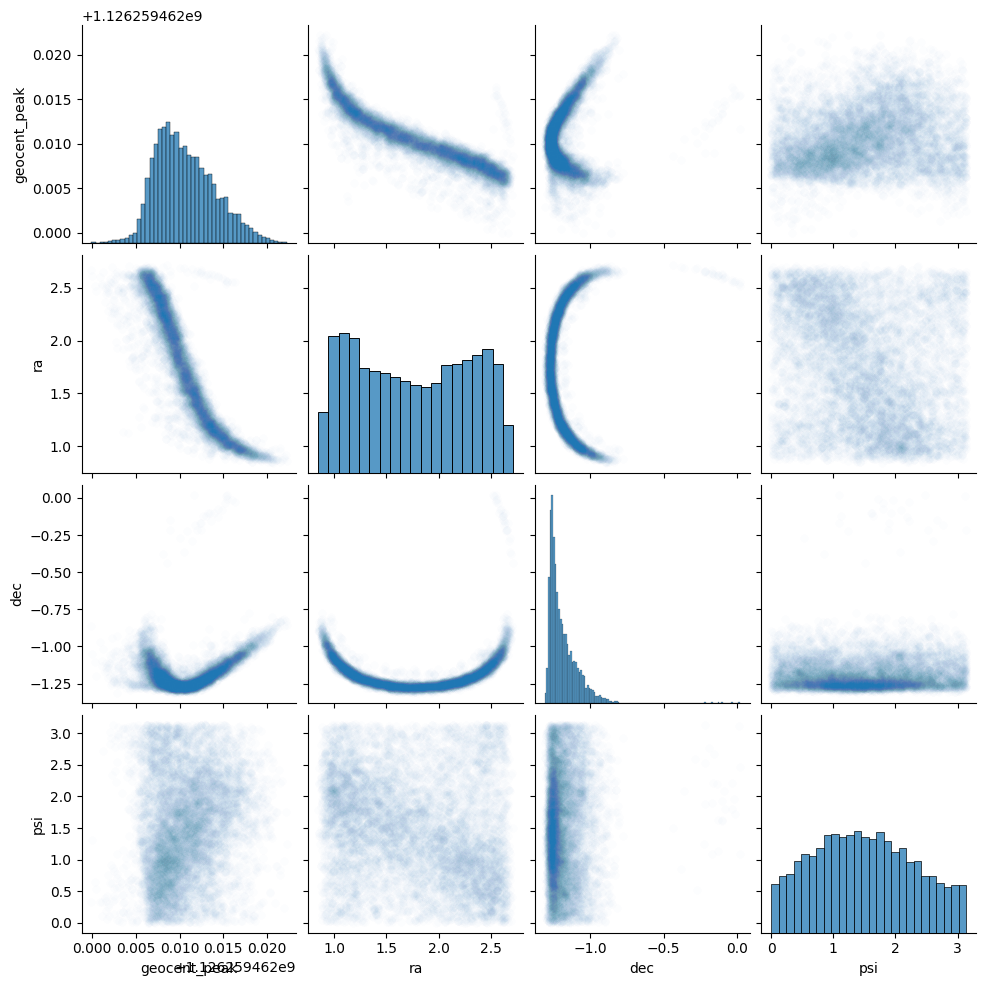

In [4]:
sns.pairplot(samps[['geocent_peak','ra','dec','psi']],plot_kws=dict(alpha=0.01))

In [5]:
from sklearn import mixture

In [6]:
g = mixture.GaussianMixture(n_components=40)

In [7]:
g.fit(samps[['geocent_peak','ra','dec','psi']])

GaussianMixture(n_components=40)

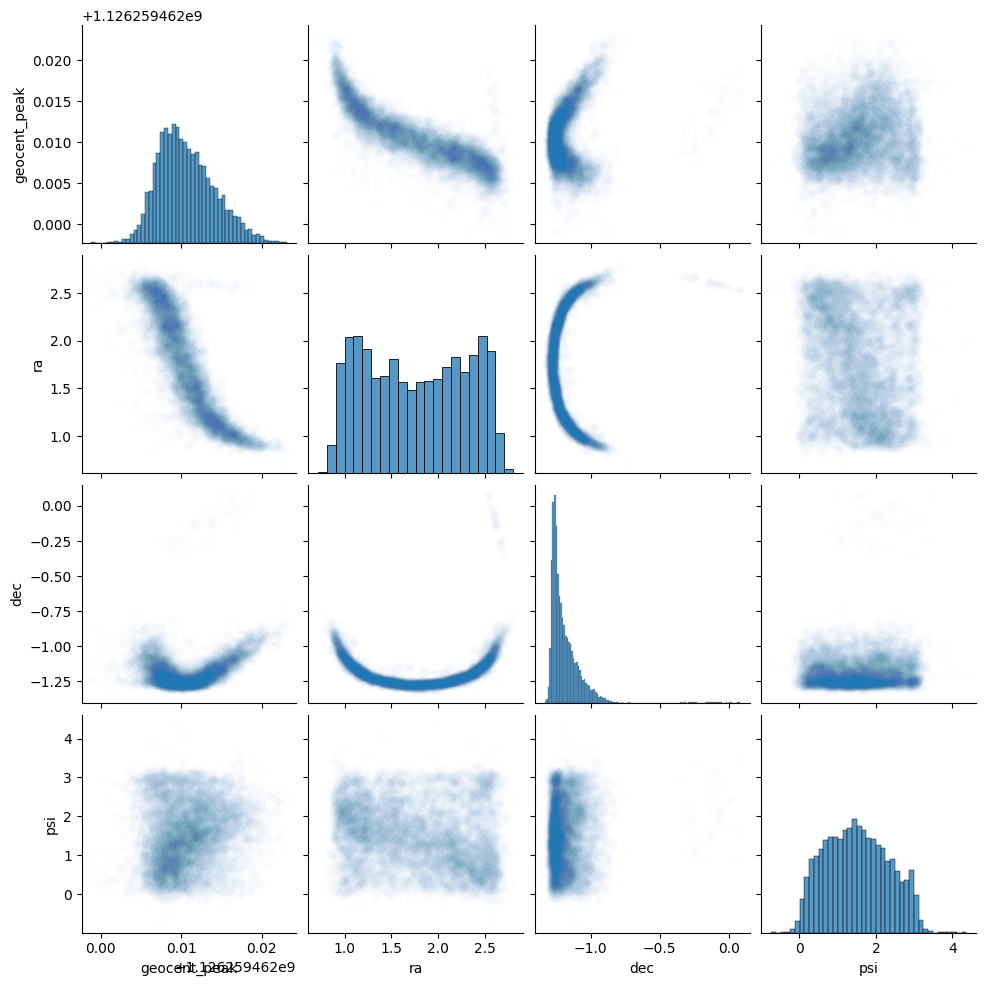

In [8]:
gg = sns.pairplot(pd.DataFrame(g.sample(8000)[0], columns=['geocent_peak','ra','dec','psi']), plot_kws=dict(alpha=0.01))

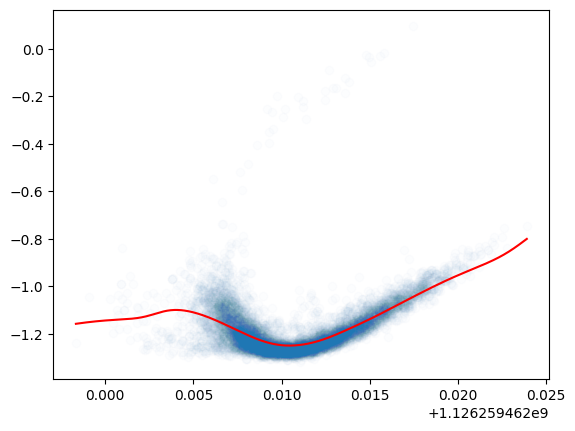

In [233]:
plt.plot(t_s, dec,'r')
plt.scatter(samps['geocent_peak'], samps['dec'], alpha=0.01)

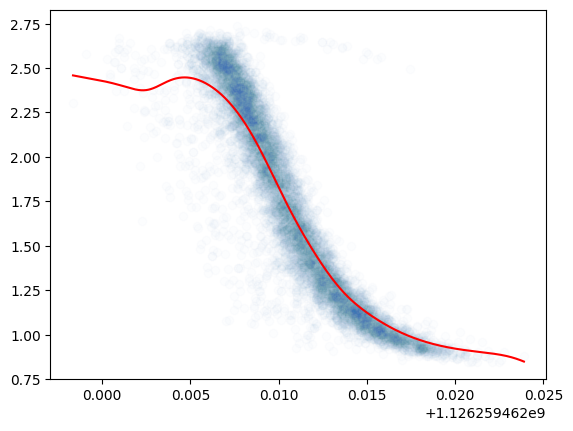

In [234]:
plt.plot(t_s, ra,'r')
plt.scatter(samps['geocent_peak'], samps['ra'], alpha=0.01)

In [138]:
k = lambda ra,dec: np.exp(g.score_samples([[t_med, ra, dec]]))

In [139]:
t_med = samps['geocent_peak'].median()

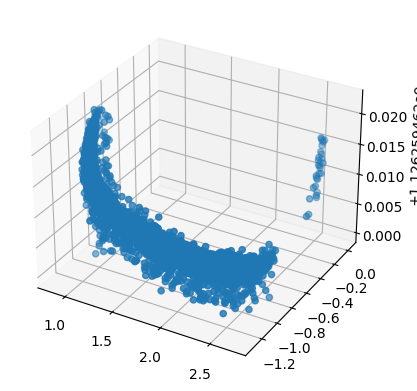

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(samps['ra'],samps['dec'], samps['geocent_peak'])

In [196]:
t_min = samps['geocent_peak'].min()
t_max = samps['geocent_peak'].max()
dt = (t_max - t_min)/100
t_s = np.linspace(t_min, t_max,1000)
t_s;

In [11]:
from matplotlib.colors import LogNorm

ra = np.zeros(10)
dec = np.zeros(10)

for i in range(10):
    # display predicted scores by the model as a contour plot
    x = np.linspace(0.0, np.pi,num=100)
    y = np.linspace(-np.pi/2, np.pi/2, num=100)
    p = np.linspace(0.0, np.pi, num=100)

    z = np.ones_like(x)*t_s[i]
    X, Y, P = np.meshgrid(x, y,p)

    XX = np.array([X.ravel(), Y.ravel()]).T

    newX = np.zeros((XX.shape[0],3))
    newX[:,1:3] = XX
    newX[:,0] = z[0]
    
    newXdf = pd.DataFrame(newX, columns=['geocent_peak','ra','dec'])

    Z = np.exp(g.score_samples(newXdf))
    Z = Z.reshape(X.shape)
    Z = Z - Z.min()

    #inds = np.unravel_index(np.argmax(Z, axis=None), Z.shape)
    #ra[i] = X[inds]
    #dec[i] = Y[inds]
    ra[i] = (X*Z).sum()/(Z).sum()
    dec[i] = (Y*Z).sum()/(Z).sum()

#CS = plt.contourf(X, Y, Z)

NameError: name 't_s' is not defined

0.1969739824305779

In [226]:
X*X

array([[0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00],
       [0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00],
       [0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00],
       ...,
       [0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00],
       [0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00],
       [0.00000000e+00, 2.49226141e-04, 9.96904563e-04, ...,
        9.67221730e+00, 9.77066162e+00, 9.86960440e+00]])

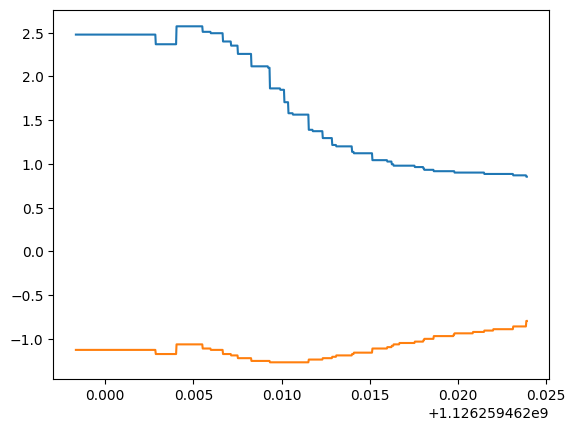

In [202]:
plt.plot(t_s, ra)
plt.plot(t_s, dec)

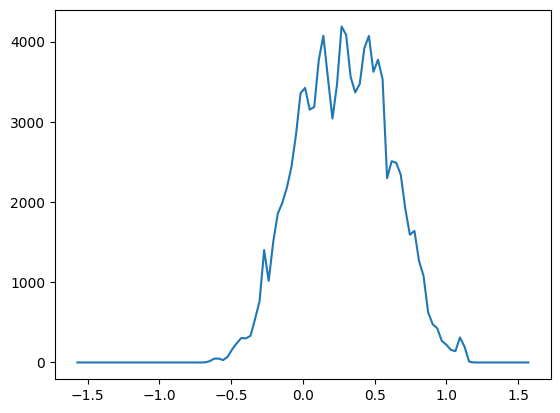

In [189]:
plt.plot(y,[Z[:,i].sum() for i in range(Z.shape[0])])

In [106]:
samp2s = pd.DataFrame(g.sample(80000)[0], columns=['geocent_peak','ra','dec'])

In [114]:
samp2s['geocent_bin'] = pd.cut(samp2s['geocent_peak'],bins=10)

In [115]:
samp2s.groupby('geocent_bin').count()

,geocent_peak,ra,dec
geocent_bin,,,
"(1126259462.398, 1126259462.4]",14,14,14
"(1126259462.4, 1126259462.403]",311,311,311
"(1126259462.403, 1126259462.406]",5663,5663,5663
"(1126259462.406, 1126259462.409]",23493,23493,23493
"(1126259462.409, 1126259462.412]",23096,23096,23096
"(1126259462.412, 1126259462.414]",15219,15219,15219
"(1126259462.414, 1126259462.417]",8133,8133,8133
"(1126259462.417, 1126259462.42]",3420,3420,3420
"(1126259462.42, 1126259462.423]",625,625,625


In [180]:
#np.argmax(Z, axis=0)


(2.1157664809890444, -1.2502256478571625)

In [184]:
(samps['geocent_peak'].max() - samps['geocent_peak'].min())/100 + 

-0.02555084228515625